In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../v1-DEBIAS-M-Analysis/')
from General_functions import data_loading, plotting
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.linear_model import LogisticRegression
from debiasm import DebiasMClassifier
import torch
from sklearn.metrics import roc_auc_score
from debiasm.torch_functions import rescale
import os

In [2]:
df, md = data_loading.load_HIVRC('../data/HIVRC/')
df_with_batch = pd.concat([pd.Series( pd.Categorical(md.Study).codes, 
                                         index=md.index), df], axis=1)    
y=md.label

In [3]:
aggregated_dfs = {}

df_tmp = df.T
df_tmp['Genus'] = df_tmp.index.str.lstrip('merged.otu:').str.split(':').str[0].str.split('_').str[0]
df_tmp['Species'] = df_tmp.index.str.lstrip('merged.otu:').str.split(':').str[0]

aggregated_dfs['Genus'] = df_tmp.groupby('Genus')[df_tmp.columns[:-2]].sum().T
aggregated_dfs['Species'] = df_tmp.groupby('Species')[df_tmp.columns[:-2]].sum().T


In [5]:
from debiasm.sklearn_functions import batch_weight_feature_and_nbatchpairs_scaling

In [6]:
logo = LeaveOneGroupOut()
all_base_rocs=[]
all_dm_rocs=[]
all_groupings=[]

seed=123

for grouping in aggregated_dfs:
    
    df = aggregated_dfs[grouping]
    df_with_batch = pd.concat([pd.Series( pd.Categorical(md.Study).codes, 
                                         index=md.index), df], axis=1)    
    df_relabund=rescale(df)
    
    for train_inds, test_inds in logo.split(df, md, md.Study):
        if md.loc[md.index[test_inds]].label.nunique()>1:
            np.random.seed(seed)
            torch.manual_seed(seed)

            dmc=DebiasMClassifier(x_val=df_with_batch.loc[df.index[test_inds]].values, 
                                  batch_str=batch_weight_feature_and_nbatchpairs_scaling(1e4, 
                                                                                         df_with_batch))
            dmc.fit(df_with_batch.loc[df.index[train_inds]].values,
                     md.loc[md.index[train_inds]].label.values
                    )
            preds = dmc.predict_proba( df_with_batch.loc[df.index[test_inds]].values )

            all_dm_rocs.append(roc_auc_score(
                                            md.loc[md.index[test_inds]].label.values, 
                                            preds[:, 1]
                                            ) )
            
            

            np.random.seed(seed)
            lr=LogisticRegression(penalty='none', 
#                                   solver='newton-cg',
                                   max_iter=1000
                                  )
            
            lr.fit(df_relabund.loc[df.index[train_inds]].values, 
                   md.loc[md.index[train_inds]].label.values
                  )
            
            preds = lr.predict_proba(df_relabund.loc[df.index[test_inds]].values)
            
            all_base_rocs.append(roc_auc_score(
                                            md.loc[md.index[test_inds]].label.values, 
                                            preds[:, 1]
                                            ) )
            
            all_groupings.append(grouping)

            
            print('Aggregation')
            print(all_groupings)
            print('Base:')
            print(all_base_rocs)
            print('DEBIAS-M:')
            print(all_dm_rocs)

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

Aggregation
['Genus']
Base:
[0.4801587301587302]
DEBIAS-M:
[0.4801587301587302]


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-p

Aggregation
['Genus', 'Genus']
Base:
[0.4801587301587302, 0.5523809523809523]
DEBIAS-M:
[0.4801587301587302, 0.5523809523809524]


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Aggregation
['Genus', 'Genus', 'Genus']
Base:
[0.4801587301587302, 0.5523809523809523, 0.32774193548387087]
DEBIAS-M:
[0.4801587301587302, 0.5523809523809524, 0.7374193548387097]


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/p

Aggregation
['Genus', 'Genus', 'Genus', 'Genus']
Base:
[0.4801587301587302, 0.5523809523809523, 0.32774193548387087, 0.5032051282051282]
DEBIAS-M:
[0.4801587301587302, 0.5523809523809524, 0.7374193548387097, 0.5064102564102564]


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  

Aggregation
['Genus', 'Genus', 'Genus', 'Genus', 'Genus']
Base:
[0.4801587301587302, 0.5523809523809523, 0.32774193548387087, 0.5032051282051282, 0.5381903642773208]
DEBIAS-M:
[0.4801587301587302, 0.5523809523809524, 0.7374193548387097, 0.5064102564102564, 0.6137877007442225]


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Aggregation
['Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus']
Base:
[0.4801587301587302, 0.5523809523809523, 0.32774193548387087, 0.5032051282051282, 0.5381903642773208, 0.4887218045112782]
DEBIAS-M:
[0.4801587301587302, 0.5523809523809524, 0.7374193548387097, 0.5064102564102564, 0.6137877007442225, 0.6867167919799498]


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Aggregation
['Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus']
Base:
[0.4801587301587302, 0.5523809523809523, 0.32774193548387087, 0.5032051282051282, 0.5381903642773208, 0.4887218045112782, 0.6067100206916938]
DEBIAS-M:
[0.4801587301587302, 0.5523809523809524, 0.7374193548387097, 0.5064102564102564, 0.6137877007442225, 0.6867167919799498, 0.5155187703221992]


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Aggregation
['Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus']
Base:
[0.4801587301587302, 0.5523809523809523, 0.32774193548387087, 0.5032051282051282, 0.5381903642773208, 0.4887218045112782, 0.6067100206916938, 0.3476702508960574]
DEBIAS-M:
[0.4801587301587302, 0.5523809523809524, 0.7374193548387097, 0.5064102564102564, 0.6137877007442225, 0.6867167919799498, 0.5155187703221992, 0.5017921146953406]


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Plea

Aggregation
['Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus']
Base:
[0.4801587301587302, 0.5523809523809523, 0.32774193548387087, 0.5032051282051282, 0.5381903642773208, 0.4887218045112782, 0.6067100206916938, 0.3476702508960574, 0.5223471741637832]
DEBIAS-M:
[0.4801587301587302, 0.5523809523809524, 0.7374193548387097, 0.5064102564102564, 0.6137877007442225, 0.6867167919799498, 0.5155187703221992, 0.5017921146953406, 0.46597462514417537]


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-p

Aggregation
['Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus']
Base:
[0.4801587301587302, 0.5523809523809523, 0.32774193548387087, 0.5032051282051282, 0.5381903642773208, 0.4887218045112782, 0.6067100206916938, 0.3476702508960574, 0.5223471741637832, 0.6575757575757576]
DEBIAS-M:
[0.4801587301587302, 0.5523809523809524, 0.7374193548387097, 0.5064102564102564, 0.6137877007442225, 0.6867167919799498, 0.5155187703221992, 0.5017921146953406, 0.46597462514417537, 0.7757575757575758]


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Aggregation
['Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus']
Base:
[0.4801587301587302, 0.5523809523809523, 0.32774193548387087, 0.5032051282051282, 0.5381903642773208, 0.4887218045112782, 0.6067100206916938, 0.3476702508960574, 0.5223471741637832, 0.6575757575757576, 0.774074074074074]
DEBIAS-M:
[0.4801587301587302, 0.5523809523809524, 0.7374193548387097, 0.5064102564102564, 0.6137877007442225, 0.6867167919799498, 0.5155187703221992, 0.5017921146953406, 0.46597462514417537, 0.7757575757575758, 0.7999999999999999]


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/p

Aggregation
['Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus']
Base:
[0.4801587301587302, 0.5523809523809523, 0.32774193548387087, 0.5032051282051282, 0.5381903642773208, 0.4887218045112782, 0.6067100206916938, 0.3476702508960574, 0.5223471741637832, 0.6575757575757576, 0.774074074074074, 0.4772727272727273]
DEBIAS-M:
[0.4801587301587302, 0.5523809523809524, 0.7374193548387097, 0.5064102564102564, 0.6137877007442225, 0.6867167919799498, 0.5155187703221992, 0.5017921146953406, 0.46597462514417537, 0.7757575757575758, 0.7999999999999999, 0.6136363636363636]


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Aggregation
['Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus']
Base:
[0.4801587301587302, 0.5523809523809523, 0.32774193548387087, 0.5032051282051282, 0.5381903642773208, 0.4887218045112782, 0.6067100206916938, 0.3476702508960574, 0.5223471741637832, 0.6575757575757576, 0.774074074074074, 0.4772727272727273, 0.3843971631205674]
DEBIAS-M:
[0.4801587301587302, 0.5523809523809524, 0.7374193548387097, 0.5064102564102564, 0.6137877007442225, 0.6867167919799498, 0.5155187703221992, 0.5017921146953406, 0.46597462514417537, 0.7757575757575758, 0.7999999999999999, 0.6136363636363636, 0.45531914893617026]


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/sklearn/linear_model/_log

Aggregation
['Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus']
Base:
[0.4801587301587302, 0.5523809523809523, 0.32774193548387087, 0.5032051282051282, 0.5381903642773208, 0.4887218045112782, 0.6067100206916938, 0.3476702508960574, 0.5223471741637832, 0.6575757575757576, 0.774074074074074, 0.4772727272727273, 0.3843971631205674, 0.6054421768707483]
DEBIAS-M:
[0.4801587301587302, 0.5523809523809524, 0.7374193548387097, 0.5064102564102564, 0.6137877007442225, 0.6867167919799498, 0.5155187703221992, 0.5017921146953406, 0.46597462514417537, 0.7757575757575758, 0.7999999999999999, 0.6136363636363636, 0.45531914893617026, 0.7327502429543244]


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:1

Aggregation
['Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus']
Base:
[0.4801587301587302, 0.5523809523809523, 0.32774193548387087, 0.5032051282051282, 0.5381903642773208, 0.4887218045112782, 0.6067100206916938, 0.3476702508960574, 0.5223471741637832, 0.6575757575757576, 0.774074074074074, 0.4772727272727273, 0.3843971631205674, 0.6054421768707483, 0.4422360248447205]
DEBIAS-M:
[0.4801587301587302, 0.5523809523809524, 0.7374193548387097, 0.5064102564102564, 0.6137877007442225, 0.6867167919799498, 0.5155187703221992, 0.5017921146953406, 0.46597462514417537, 0.7757575757575758, 0.7999999999999999, 0.6136363636363636, 0.45531914893617026, 0.7327502429543244, 0.6223602484472051]


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_c

Aggregation
['Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Species']
Base:
[0.4801587301587302, 0.5523809523809523, 0.32774193548387087, 0.5032051282051282, 0.5381903642773208, 0.4887218045112782, 0.6067100206916938, 0.3476702508960574, 0.5223471741637832, 0.6575757575757576, 0.774074074074074, 0.4772727272727273, 0.3843971631205674, 0.6054421768707483, 0.4422360248447205, 0.5634920634920635]
DEBIAS-M:
[0.4801587301587302, 0.5523809523809524, 0.7374193548387097, 0.5064102564102564, 0.6137877007442225, 0.6867167919799498, 0.5155187703221992, 0.5017921146953406, 0.46597462514417537, 0.7757575757575758, 0.7999999999999999, 0.6136363636363636, 0.45531914893617026, 0.7327502429543244, 0.6223602484472051, 0.7222222222222222]


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/p

Aggregation
['Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Species', 'Species']
Base:
[0.4801587301587302, 0.5523809523809523, 0.32774193548387087, 0.5032051282051282, 0.5381903642773208, 0.4887218045112782, 0.6067100206916938, 0.3476702508960574, 0.5223471741637832, 0.6575757575757576, 0.774074074074074, 0.4772727272727273, 0.3843971631205674, 0.6054421768707483, 0.4422360248447205, 0.5634920634920635, 0.726984126984127]
DEBIAS-M:
[0.4801587301587302, 0.5523809523809524, 0.7374193548387097, 0.5064102564102564, 0.6137877007442225, 0.6867167919799498, 0.5155187703221992, 0.5017921146953406, 0.46597462514417537, 0.7757575757575758, 0.7999999999999999, 0.6136363636363636, 0.45531914893617026, 0.7327502429543244, 0.6223602484472051, 0.7222222222222222, 0.6507936507936507]


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Aggregation
['Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Species', 'Species', 'Species']
Base:
[0.4801587301587302, 0.5523809523809523, 0.32774193548387087, 0.5032051282051282, 0.5381903642773208, 0.4887218045112782, 0.6067100206916938, 0.3476702508960574, 0.5223471741637832, 0.6575757575757576, 0.774074074074074, 0.4772727272727273, 0.3843971631205674, 0.6054421768707483, 0.4422360248447205, 0.5634920634920635, 0.726984126984127, 0.2496774193548387]
DEBIAS-M:
[0.4801587301587302, 0.5523809523809524, 0.7374193548387097, 0.5064102564102564, 0.6137877007442225, 0.6867167919799498, 0.5155187703221992, 0.5017921146953406, 0.46597462514417537, 0.7757575757575758, 0.7999999999999999, 0.6136363636363636, 0.45531914893617026, 0.7327502429543244, 0.6223602484472051, 0.7222222222222222, 0.6507936507936507, 0.6541935483870968]


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/p

Aggregation
['Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Species', 'Species', 'Species', 'Species']
Base:
[0.4801587301587302, 0.5523809523809523, 0.32774193548387087, 0.5032051282051282, 0.5381903642773208, 0.4887218045112782, 0.6067100206916938, 0.3476702508960574, 0.5223471741637832, 0.6575757575757576, 0.774074074074074, 0.4772727272727273, 0.3843971631205674, 0.6054421768707483, 0.4422360248447205, 0.5634920634920635, 0.726984126984127, 0.2496774193548387, 0.3589743589743589]
DEBIAS-M:
[0.4801587301587302, 0.5523809523809524, 0.7374193548387097, 0.5064102564102564, 0.6137877007442225, 0.6867167919799498, 0.5155187703221992, 0.5017921146953406, 0.46597462514417537, 0.7757575757575758, 0.7999999999999999, 0.6136363636363636, 0.45531914893617026, 0.7327502429543244, 0.6223602484472051, 0.7222222222222222, 0.6507936507936507, 0.6541935483870968, 0.6762820512820512]


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/p

Aggregation
['Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Species', 'Species', 'Species', 'Species', 'Species']
Base:
[0.4801587301587302, 0.5523809523809523, 0.32774193548387087, 0.5032051282051282, 0.5381903642773208, 0.4887218045112782, 0.6067100206916938, 0.3476702508960574, 0.5223471741637832, 0.6575757575757576, 0.774074074074074, 0.4772727272727273, 0.3843971631205674, 0.6054421768707483, 0.4422360248447205, 0.5634920634920635, 0.726984126984127, 0.2496774193548387, 0.3589743589743589, 0.46709753231492357]
DEBIAS-M:
[0.4801587301587302, 0.5523809523809524, 0.7374193548387097, 0.5064102564102564, 0.6137877007442225, 0.6867167919799498, 0.5155187703221992, 0.5017921146953406, 0.46597462514417537, 0.7757575757575758, 0.7999999999999999, 0.6136363636363636, 0.45531914893617026, 0.7327502429543244, 0.6223602484472051, 0.7222222222222222, 0.6507936507936507, 0.6541935483870968, 0.676282051282051

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Aggregation
['Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Species', 'Species', 'Species', 'Species', 'Species', 'Species']
Base:
[0.4801587301587302, 0.5523809523809523, 0.32774193548387087, 0.5032051282051282, 0.5381903642773208, 0.4887218045112782, 0.6067100206916938, 0.3476702508960574, 0.5223471741637832, 0.6575757575757576, 0.774074074074074, 0.4772727272727273, 0.3843971631205674, 0.6054421768707483, 0.4422360248447205, 0.5634920634920635, 0.726984126984127, 0.2496774193548387, 0.3589743589743589, 0.46709753231492357, 0.6015037593984962]
DEBIAS-M:
[0.4801587301587302, 0.5523809523809524, 0.7374193548387097, 0.5064102564102564, 0.6137877007442225, 0.6867167919799498, 0.5155187703221992, 0.5017921146953406, 0.46597462514417537, 0.7757575757575758, 0.7999999999999999, 0.6136363636363636, 0.45531914893617026, 0.7327502429543244, 0.6223602484472051, 0.7222222222222222, 0.6507936507936507, 0.6541

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Aggregation
['Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Species', 'Species', 'Species', 'Species', 'Species', 'Species', 'Species']
Base:
[0.4801587301587302, 0.5523809523809523, 0.32774193548387087, 0.5032051282051282, 0.5381903642773208, 0.4887218045112782, 0.6067100206916938, 0.3476702508960574, 0.5223471741637832, 0.6575757575757576, 0.774074074074074, 0.4772727272727273, 0.3843971631205674, 0.6054421768707483, 0.4422360248447205, 0.5634920634920635, 0.726984126984127, 0.2496774193548387, 0.3589743589743589, 0.46709753231492357, 0.6015037593984962, 0.582323381613952]
DEBIAS-M:
[0.4801587301587302, 0.5523809523809524, 0.7374193548387097, 0.5064102564102564, 0.6137877007442225, 0.6867167919799498, 0.5155187703221992, 0.5017921146953406, 0.46597462514417537, 0.7757575757575758, 0.7999999999999999, 0.6136363636363636, 0.45531914893617026, 0.7327502429543244, 0.6223602484472051, 0.72222222222222

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_c

Aggregation
['Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Species', 'Species', 'Species', 'Species', 'Species', 'Species', 'Species', 'Species']
Base:
[0.4801587301587302, 0.5523809523809523, 0.32774193548387087, 0.5032051282051282, 0.5381903642773208, 0.4887218045112782, 0.6067100206916938, 0.3476702508960574, 0.5223471741637832, 0.6575757575757576, 0.774074074074074, 0.4772727272727273, 0.3843971631205674, 0.6054421768707483, 0.4422360248447205, 0.5634920634920635, 0.726984126984127, 0.2496774193548387, 0.3589743589743589, 0.46709753231492357, 0.6015037593984962, 0.582323381613952, 0.47311827956989244]
DEBIAS-M:
[0.4801587301587302, 0.5523809523809524, 0.7374193548387097, 0.5064102564102564, 0.6137877007442225, 0.6867167919799498, 0.5155187703221992, 0.5017921146953406, 0.46597462514417537, 0.7757575757575758, 0.7999999999999999, 0.6136363636363636, 0.45531914893617026, 0.7327502429543244, 0.62

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/sklearn/linear_model/_log

Aggregation
['Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Species', 'Species', 'Species', 'Species', 'Species', 'Species', 'Species', 'Species', 'Species']
Base:
[0.4801587301587302, 0.5523809523809523, 0.32774193548387087, 0.5032051282051282, 0.5381903642773208, 0.4887218045112782, 0.6067100206916938, 0.3476702508960574, 0.5223471741637832, 0.6575757575757576, 0.774074074074074, 0.4772727272727273, 0.3843971631205674, 0.6054421768707483, 0.4422360248447205, 0.5634920634920635, 0.726984126984127, 0.2496774193548387, 0.3589743589743589, 0.46709753231492357, 0.6015037593984962, 0.582323381613952, 0.47311827956989244, 0.5317185697808535]
DEBIAS-M:
[0.4801587301587302, 0.5523809523809524, 0.7374193548387097, 0.5064102564102564, 0.6137877007442225, 0.6867167919799498, 0.5155187703221992, 0.5017921146953406, 0.46597462514417537, 0.7757575757575758, 0.7999999999999999, 0.6136363636363636, 0.455319148936

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-p

Aggregation
['Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Species', 'Species', 'Species', 'Species', 'Species', 'Species', 'Species', 'Species', 'Species', 'Species']
Base:
[0.4801587301587302, 0.5523809523809523, 0.32774193548387087, 0.5032051282051282, 0.5381903642773208, 0.4887218045112782, 0.6067100206916938, 0.3476702508960574, 0.5223471741637832, 0.6575757575757576, 0.774074074074074, 0.4772727272727273, 0.3843971631205674, 0.6054421768707483, 0.4422360248447205, 0.5634920634920635, 0.726984126984127, 0.2496774193548387, 0.3589743589743589, 0.46709753231492357, 0.6015037593984962, 0.582323381613952, 0.47311827956989244, 0.5317185697808535, 0.5333333333333333]
DEBIAS-M:
[0.4801587301587302, 0.5523809523809524, 0.7374193548387097, 0.5064102564102564, 0.6137877007442225, 0.6867167919799498, 0.5155187703221992, 0.5017921146953406, 0.46597462514417537, 0.7757575757575758, 0.7999999999999999, 0.6

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Aggregation
['Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Species', 'Species', 'Species', 'Species', 'Species', 'Species', 'Species', 'Species', 'Species', 'Species', 'Species']
Base:
[0.4801587301587302, 0.5523809523809523, 0.32774193548387087, 0.5032051282051282, 0.5381903642773208, 0.4887218045112782, 0.6067100206916938, 0.3476702508960574, 0.5223471741637832, 0.6575757575757576, 0.774074074074074, 0.4772727272727273, 0.3843971631205674, 0.6054421768707483, 0.4422360248447205, 0.5634920634920635, 0.726984126984127, 0.2496774193548387, 0.3589743589743589, 0.46709753231492357, 0.6015037593984962, 0.582323381613952, 0.47311827956989244, 0.5317185697808535, 0.5333333333333333, 0.6074074074074074]
DEBIAS-M:
[0.4801587301587302, 0.5523809523809524, 0.7374193548387097, 0.5064102564102564, 0.6137877007442225, 0.6867167919799498, 0.5155187703221992, 0.5017921146953406, 0.46597462514417537, 0.7757575757

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

Aggregation
['Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Species', 'Species', 'Species', 'Species', 'Species', 'Species', 'Species', 'Species', 'Species', 'Species', 'Species', 'Species']
Base:
[0.4801587301587302, 0.5523809523809523, 0.32774193548387087, 0.5032051282051282, 0.5381903642773208, 0.4887218045112782, 0.6067100206916938, 0.3476702508960574, 0.5223471741637832, 0.6575757575757576, 0.774074074074074, 0.4772727272727273, 0.3843971631205674, 0.6054421768707483, 0.4422360248447205, 0.5634920634920635, 0.726984126984127, 0.2496774193548387, 0.3589743589743589, 0.46709753231492357, 0.6015037593984962, 0.582323381613952, 0.47311827956989244, 0.5317185697808535, 0.5333333333333333, 0.6074074074074074, 0.6590909090909092]
DEBIAS-M:
[0.4801587301587302, 0.5523809523809524, 0.7374193548387097, 0.5064102564102564, 0.6137877007442225, 0.6867167919799498, 0.5155187703221992, 0.5017921146953406, 0.

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-p

Aggregation
['Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Species', 'Species', 'Species', 'Species', 'Species', 'Species', 'Species', 'Species', 'Species', 'Species', 'Species', 'Species', 'Species']
Base:
[0.4801587301587302, 0.5523809523809523, 0.32774193548387087, 0.5032051282051282, 0.5381903642773208, 0.4887218045112782, 0.6067100206916938, 0.3476702508960574, 0.5223471741637832, 0.6575757575757576, 0.774074074074074, 0.4772727272727273, 0.3843971631205674, 0.6054421768707483, 0.4422360248447205, 0.5634920634920635, 0.726984126984127, 0.2496774193548387, 0.3589743589743589, 0.46709753231492357, 0.6015037593984962, 0.582323381613952, 0.47311827956989244, 0.5317185697808535, 0.5333333333333333, 0.6074074074074074, 0.6590909090909092, 0.5148936170212766]
DEBIAS-M:
[0.4801587301587302, 0.5523809523809524, 0.7374193548387097, 0.5064102564102564, 0.6137877007442225, 0.6867167919799498, 0.515518770

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/p

Aggregation
['Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Genus', 'Species', 'Species', 'Species', 'Species', 'Species', 'Species', 'Species', 'Species', 'Species', 'Species', 'Species', 'Species', 'Species', 'Species']
Base:
[0.4801587301587302, 0.5523809523809523, 0.32774193548387087, 0.5032051282051282, 0.5381903642773208, 0.4887218045112782, 0.6067100206916938, 0.3476702508960574, 0.5223471741637832, 0.6575757575757576, 0.774074074074074, 0.4772727272727273, 0.3843971631205674, 0.6054421768707483, 0.4422360248447205, 0.5634920634920635, 0.726984126984127, 0.2496774193548387, 0.3589743589743589, 0.46709753231492357, 0.6015037593984962, 0.582323381613952, 0.47311827956989244, 0.5317185697808535, 0.5333333333333333, 0.6074074074074074, 0.6590909090909092, 0.5148936170212766, 0.5451895043731779]
DEBIAS-M:
[0.4801587301587302, 0.5523809523809524, 0.7374193548387097, 0.5064102564102564, 0.6137877007442225, 

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [17]:
test_sds=[]
for train_inds, test_inds in logo.split(df_with_batch, y, md.Study):
    if y[test_inds].nunique()>1:
        test_sds.append( df_with_batch.values[test_inds][0, 0] )
        
base_dm_otu_rocs = list( pd.read_csv('../results/HIVRC/auroc-boxplot-linear.csv')\
                                    .query("Group=='debias-m'").auROC.values )

base_dm_otu_rocs=list( pd.DataFrame({'auc':base_dm_otu_rocs, 
                'ord':[a for a in df_with_batch[0].unique() if a in test_sds]
                }).sort_values('ord').auc.values )

base_reg_otu_rocs = list( pd.read_csv('../results/HIVRC/auroc-boxplot-linear.csv')\
                                    .query("Group=='linear'").auROC.values )

base_reg_otu_rocs=list( pd.DataFrame({'auc':base_reg_otu_rocs, 
                'ord':[a for a in df_with_batch[0].unique() if a in test_sds]
                }).sort_values('ord').auc.values )

# base_dm_otu_rocs

In [16]:
base_reg_otu_rocs = list( pd.read_csv('../results/HIVRC/auroc-boxplot-linear.csv')\
                                    .query("Group=='linear'").auROC.values )

base_reg_otu_rocs=list( pd.DataFrame({'auc':base_reg_otu_rocs, 
                'ord':[a for a in df_with_batch[0].unique() if a in test_sds]
                }).sort_values('ord').auc.values )

# base_reg_otu_rocs

In [9]:
# all_dm_rocs

In [15]:
# all_results

In [20]:
order = ['OTU', 'Species', 'Genus'][::-1]

all_results = pd.DataFrame({'auROC':all_base_rocs + all_dm_rocs, 
                            'Group':['Raw']*len(all_base_rocs) + ['DEBIAS-M']*len(all_dm_rocs),
                            'Aggregation':all_groupings*2
                            })

pal=plotting.global_palette
pal['Raw'] = pal['linear']
pal['DEBIAS-M'] = pal['debias-m']

gran_base_results = pd.DataFrame({'auROC':base_reg_otu_rocs + base_dm_otu_rocs, 
                            'Group':['Raw']*len(base_reg_otu_rocs) + ['DEBIAS-M']*len(base_dm_otu_rocs),
                            'Aggregation':'OTU'
                            })

all_results = pd.concat([all_results, gran_base_results])

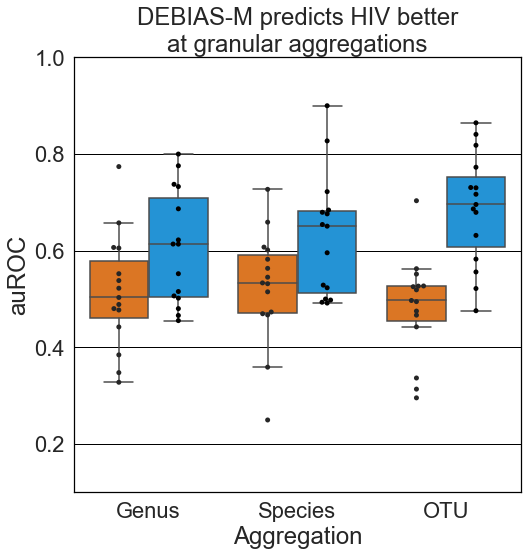

In [31]:
plt.figure(figsize=(8,8))
ax=sns.boxplot(y='auROC', 
               x='Aggregation',
               hue='Group', 
               data = all_results, 
               fliersize=0,
               order=order,
               palette=pal
               )

handles, labels = ax.get_legend_handles_labels()

sns.swarmplot(hue='Group', 
              y='auROC', 
              x='Aggregation',
              data = all_results,
              color='black',
              s=5,
              order=order, 
              dodge=True, 
              )


ax.legend(handles[:2], labels[:2])
plt.legend().remove()

plt.yticks([.2, .4, .6, .8, 1])
plt.ylim(0.1, 1)

plt.title('DEBIAS-M predicts HIV better\nat granular aggregations')
plt.savefig('../results/taxonomy-aggregation/agg-HIV-results.pdf', 
            format='pdf', 
            dpi=900, 
            bbox_inches='tight'
            )

In [24]:
from scipy.stats import wilcoxon

In [33]:
{a: wilcoxon(
    all_results.loc[(all_results.Group=='Raw')&\
                    (all_results.Aggregation==a)].auROC, 
    all_results.loc[(all_results.Group=='DEBIAS-M')&\
                    (all_results.Aggregation==a)].auROC )
 for a in all_results.Aggregation.unique() }

{'Genus': WilcoxonResult(statistic=11.0, pvalue=0.00918142110309248),
 'Species': WilcoxonResult(statistic=27.0, pvalue=0.063720703125),
 'OTU': WilcoxonResult(statistic=7.0, pvalue=0.00115966796875)}

In [34]:
[ str({(a,b): wilcoxon(
            all_results.loc[(all_results.Group=='DEBIAS-M')&\
                            (all_results.Aggregation==a)].auROC, 
            all_results.loc[(all_results.Group=='DEBIAS-M')&\
                            (all_results.Aggregation==b)].auROC )
         for a in all_results.Aggregation.unique() if a !=b })
                  
          for b in all_results.Aggregation.unique()]

["{('Species', 'Genus'): WilcoxonResult(statistic=46.0, pvalue=0.45428466796875), ('OTU', 'Genus'): WilcoxonResult(statistic=20.0, pvalue=0.02154541015625)}",
 "{('Genus', 'Species'): WilcoxonResult(statistic=46.0, pvalue=0.45428466796875), ('OTU', 'Species'): WilcoxonResult(statistic=19.0, pvalue=0.01806640625)}",
 "{('Genus', 'OTU'): WilcoxonResult(statistic=20.0, pvalue=0.02154541015625), ('Species', 'OTU'): WilcoxonResult(statistic=19.0, pvalue=0.01806640625)}"]